# Import Libraries

The below block imports all needed libraries. Feel free to add additional libraries that you need and rerun below block.

Two last lines inform you of the Pytorch version and the availability of GPU.
The last line should print `GPU availability: True`.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.transforms as transforms

print('Pytorch version: ', torch.__version__)
print('GPU availability: ', torch.cuda.is_available())

Pytorch version:  1.12.1+cu113
GPU availability:  True


# Download Dataset
If you are familiar with Linux bash scripts, you can put `!` at the beginning of a command to order Colab of interpreting it as bash scripts instead of python scripts.

The below block downloads MNIST dataset and decompresses it.

In [2]:
!wget https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz
!tar xzf mnist_png.tar.gz

--2022-11-09 01:05:51--  https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz [following]
--2022-11-09 01:05:51--  https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15683414 (15M) [application/octet-stream]
Saving to: ‘mnist_png.tar.gz’

mnist_png.tar.gz    100%[===================>]  14.96M  --.-KB/s    in 0.08s   

2022-11-09 01:05:52 (190 MB/s) - ‘mnist_png.tar.gz’ saved [15683414/15683414]



# Define Dataset Class

**TODO1:** Complete ```def apply_noise(self, im)``` to add a Gaussian noise of $\mathcal{N}(0, 0.5)$ (mean of 0 and standard derivative of 0.5).

In [3]:
# Define Dataset:
class MNISTDataset(Dataset):
    def __init__(self, root, transform=None):
        # `root` is expected to contain 10 sub-directories, each of which is named after the label of all images included inside.
        # transform is a Torchvision.Transforms object that pre-processes an image 
        self.root = root
        self.transform = transform

        self.images = list()

        for label in os.listdir(root):
            subdir = os.path.join(root, label)
            for im_name in os.listdir(subdir):
                im = plt.imread(os.path.join(subdir, im_name))
                self.images.append(im)
        self.dataset_size = len(self.images)

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, index):
        im = self.transform(self.images[index]) if self.transform is not None else self.images[index]
        noised_im = self.apply_noise(im)
        return noised_im, im

    def apply_noise(self, im):
        row,col,ch= im.shape
        mean = 0
        sigma = 0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = im + gauss
        return noisy

    def show_random(self, num_samples=8):
        indices = np.random.randint(0, len(self), [num_samples,])
        f, ax = plt.subplots(num_samples, 2, figsize=(10, 10))
        for i in range(num_samples):
            noised_im, im = self[indices[i]]
            ax[i, 0].imshow(im[0].numpy())
            ax[i, 1].imshow(noised_im[0].numpy())
        plt.show()

# Create MNISTDataset objects and dataloaders 
Below, we create the objects to process training and testing sets of MNIST data.
As there are no held-out validation set, we manually split the training set into training and validation subsets with the ratio of 8:2.

After creating dataset objects, we wrap them by a Pytorch Dataloader to allow several necessary features in training deep learning models, e.g., mini-batch feeding, shuffling.

***Note***: if you successfully complete `__init__` function of `MNISTDataset`, its `show_random` function would successfully randomly show 8 images and corresponding noisy images in the dataset.

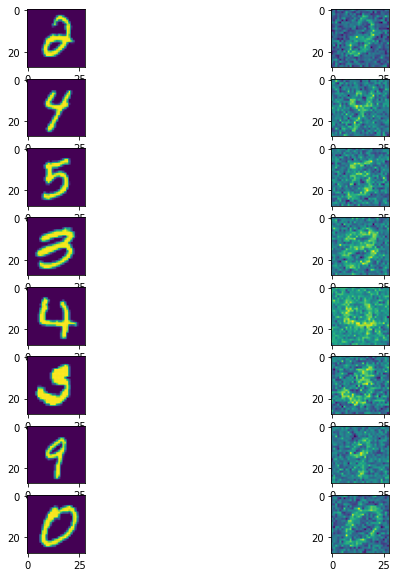

Training set size:  48000
Validation set size:  12000
Testing set size:  10000


In [4]:
################################################################
# Hyper parameters
################################################################
BATCH_SIZE = 1024
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

################################################################
# Create training and testing dataset and show random examples
################################################################
trainval_set = MNISTDataset('mnist_png/training', transform=transform)
trainval_set.show_random()

test_set = MNISTDataset('mnist_png/testing', transform=transform)

################################################################
# As there is no validation set
# We split training dataset into training and validation sets
################################################################
train_size = int(0.8 * len(trainval_set))
val_size = len(trainval_set) - train_size
train_set, val_set = torch.utils.data.random_split(
    dataset=trainval_set,
    lengths=[train_size, val_size],
    generator=torch.Generator().manual_seed(42))

################################################################
# Print lengths of subsets
################################################################
print('Training set size: ', len(train_set))
print('Validation set size: ', len(val_set))
print('Testing set size: ', len(test_set))

################################################################
# Print lengths of subsets
################################################################
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=BATCH_SIZE,
    shuffle=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False)

#TODO2: Create Autoencoder network based on MLP

Create an Autoencoder with an encoder and a decoder that are MLPs following the below descriptions:

- Encoder: 3 linear layers of 512, 128, 128 perceptrons. The first two layers having ReLU activation function, and the last layer do **NOT** have activation function.

- Decoder: 4 linear layers of 128, 512, 28\*28 perceptrons. The first two layers having ReLU activation function, and the last layer do **NOT** have activation function.

The Encoder will process the noisy input image of size 28x28 from MNIST and encode it into a 128-dimension vector.

Then, the Decoder will process the 128-dimension vector from Encoder and decode it into 28x28 image.

# TODO3: Implement the training, validating and testing processes

The network should be trained on training set following below descriptions:
- Number of epochs: 100
- Learning rate: 0.0001
- Optimizer: AdamW
- Loss function: L1 Loss

After each epoch, evaluate the model on validation set and save the best performed model to a checkpoint. Eventually, please load the best checkpoint and test it on testing set.

Please plot a graph showing the training progress, which should include two line plots for training loss and validation loss at every epoch.

# TODO4: Change loss function to L2 Loss (Mean squared error)

Please follow the training and testing requirements as in **TODO3**. Then, plot a graph showing the training progress, which should include two line plots for training loss and validation loss at every epoch.

In [20]:
# 28*28 ==> 128 ==> 28*28
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 28 * 28),
        )
 
    def forward(self, x):
        # Flatten image array
        x = torch.reshape(x, (x.shape[0], 28 * 28)).float()
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = torch.reshape(decoded, (x.shape[0], 28 , 28)).squeeze().float()
        return decoded


def eval_validation(model: AE):
  criterion = nn.L1Loss()
  for x, label in iter(val_loader):
    # Calulate distance between model predictions and value
    out = model(x)

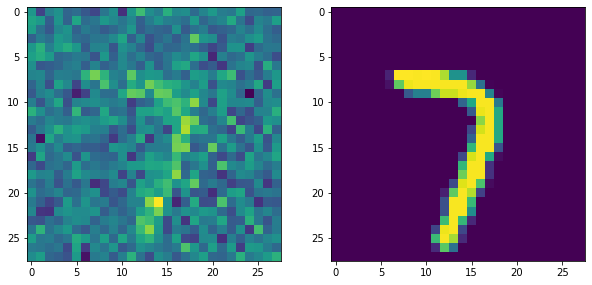

Epoch [0/100], Loss: 0.1636, Validation Loss 0.1336


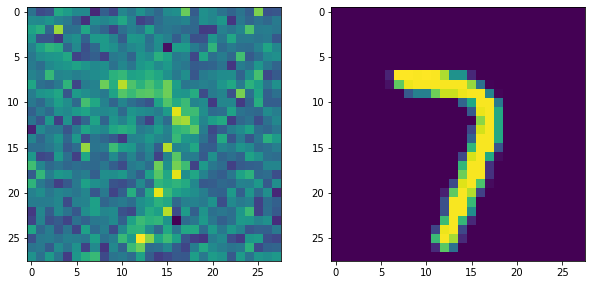

Epoch [1/100], Loss: 0.1286, Validation Loss 0.1202


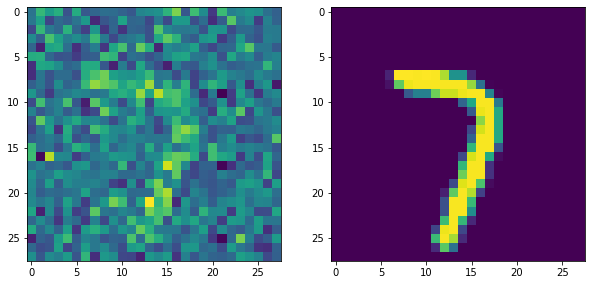

Epoch [2/100], Loss: 0.1151, Validation Loss 0.1106


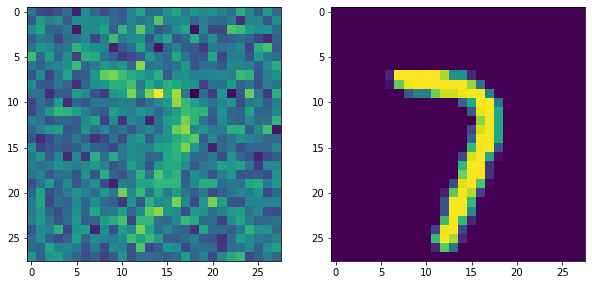

Epoch [3/100], Loss: 0.1057, Validation Loss 0.1011


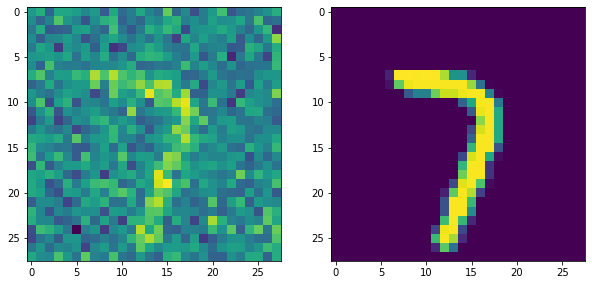

Epoch [4/100], Loss: 0.0992, Validation Loss 0.0963


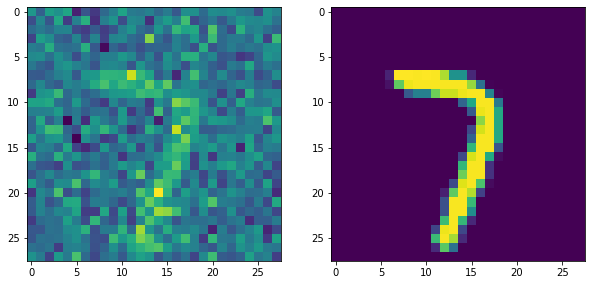

Epoch [5/100], Loss: 0.0945, Validation Loss 0.0919


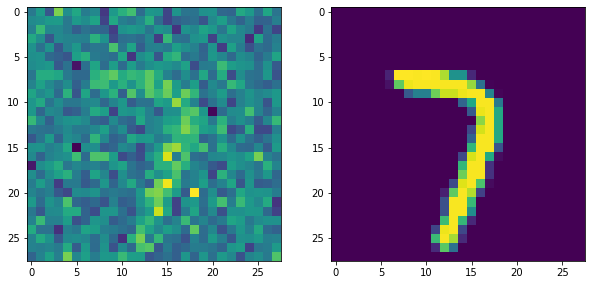

Epoch [6/100], Loss: 0.0904, Validation Loss 0.0886


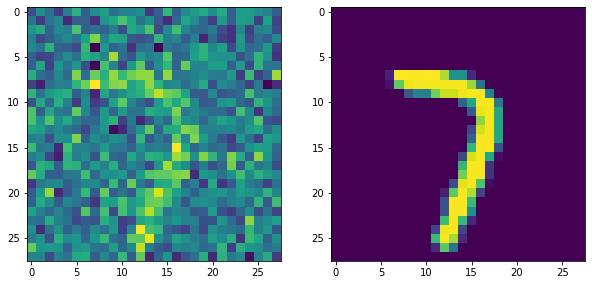

Epoch [7/100], Loss: 0.0873, Validation Loss 0.0859


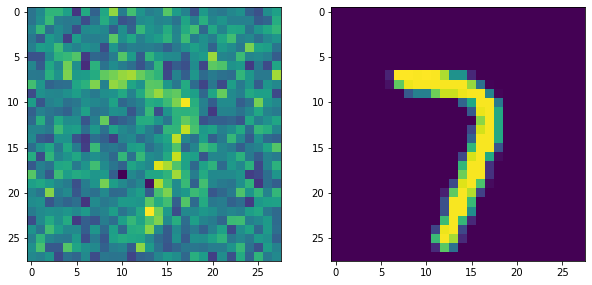

Epoch [8/100], Loss: 0.0849, Validation Loss 0.0834


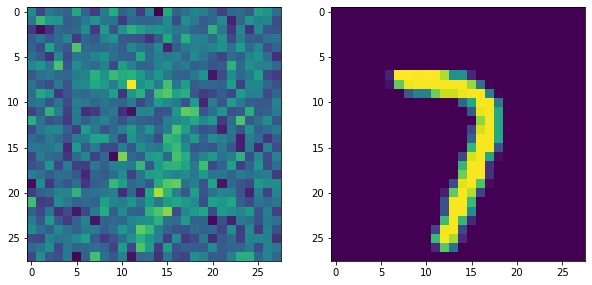

Epoch [9/100], Loss: 0.0831, Validation Loss 0.0818


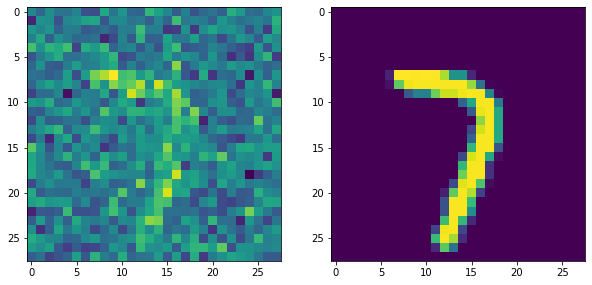

Epoch [10/100], Loss: 0.0815, Validation Loss 0.0804


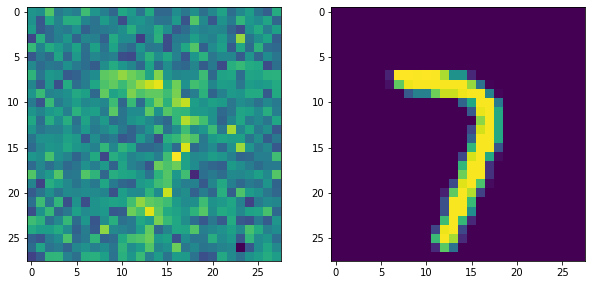

Epoch [11/100], Loss: 0.0802, Validation Loss 0.0790


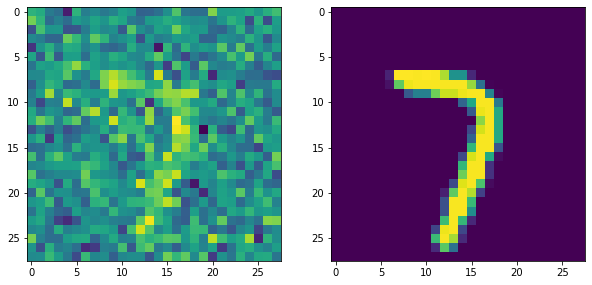

Epoch [12/100], Loss: 0.0788, Validation Loss 0.0777


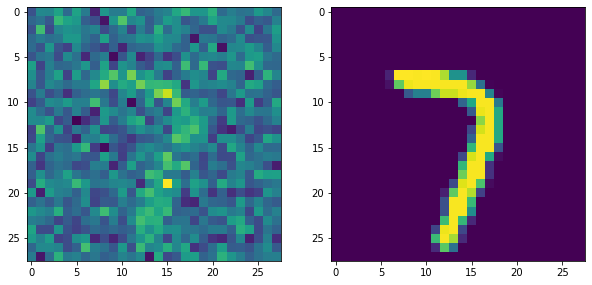

Epoch [13/100], Loss: 0.0775, Validation Loss 0.0765


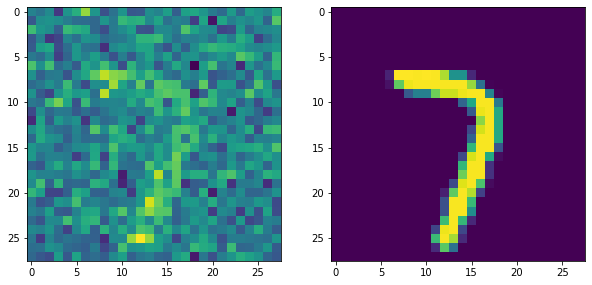

Epoch [14/100], Loss: 0.0765, Validation Loss 0.0754


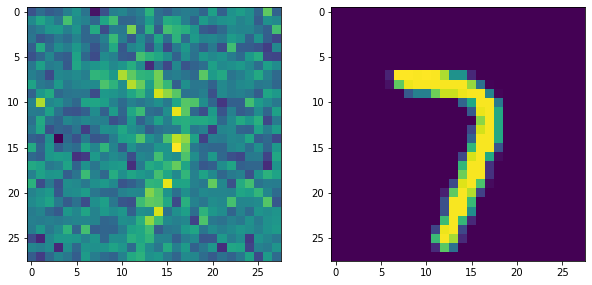

Epoch [15/100], Loss: 0.0754, Validation Loss 0.0746


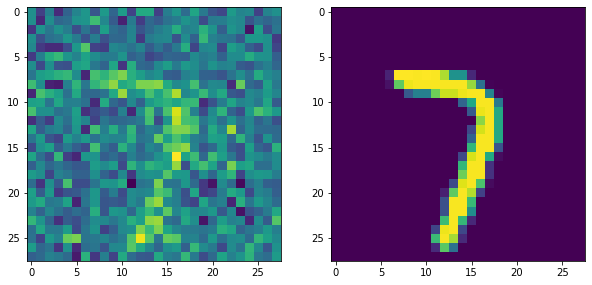

Epoch [16/100], Loss: 0.0745, Validation Loss 0.0737


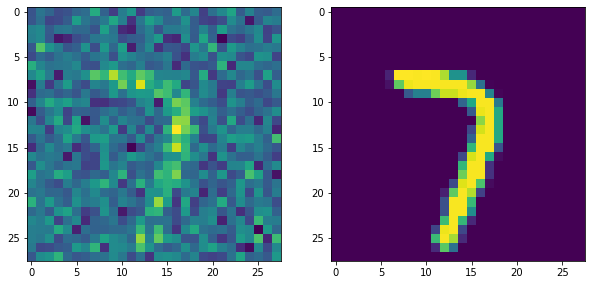

Epoch [17/100], Loss: 0.0736, Validation Loss 0.0728


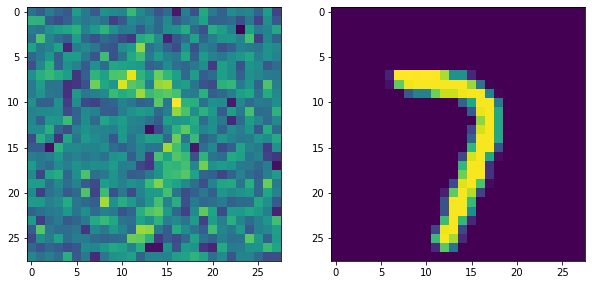

Epoch [18/100], Loss: 0.0729, Validation Loss 0.0722


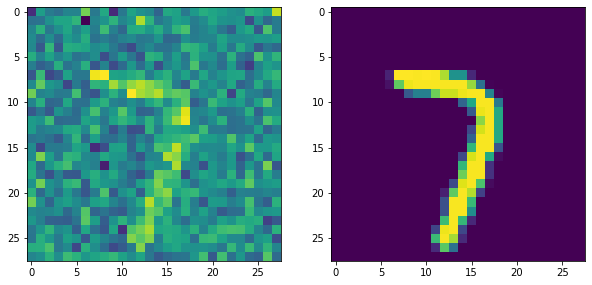

Epoch [19/100], Loss: 0.0721, Validation Loss 0.0714


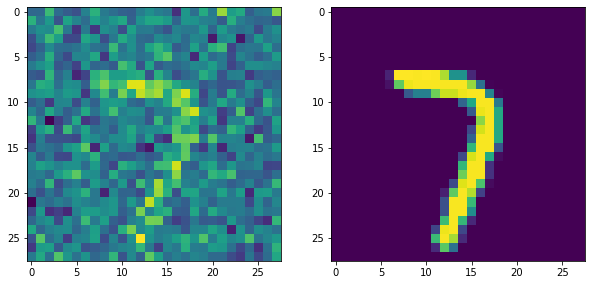

Epoch [20/100], Loss: 0.0716, Validation Loss 0.0710


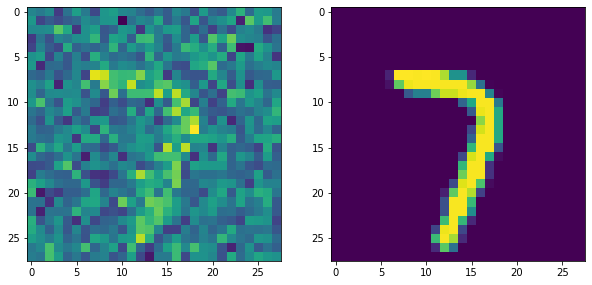

Epoch [21/100], Loss: 0.0709, Validation Loss 0.0702


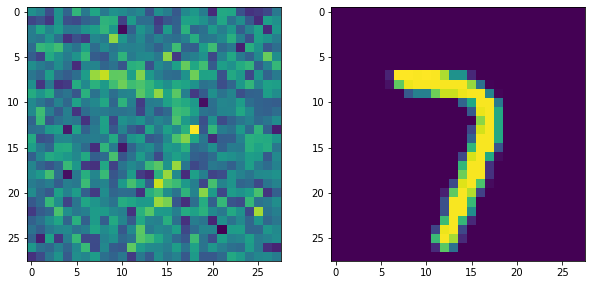

Epoch [22/100], Loss: 0.0704, Validation Loss 0.0699


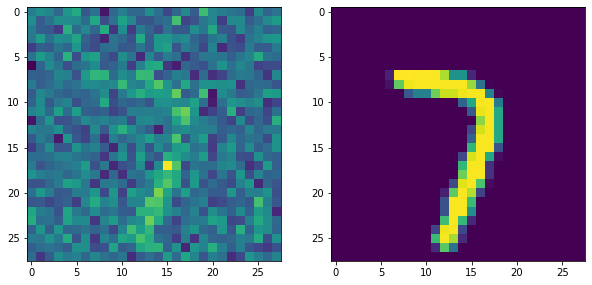

Epoch [23/100], Loss: 0.0698, Validation Loss 0.0692


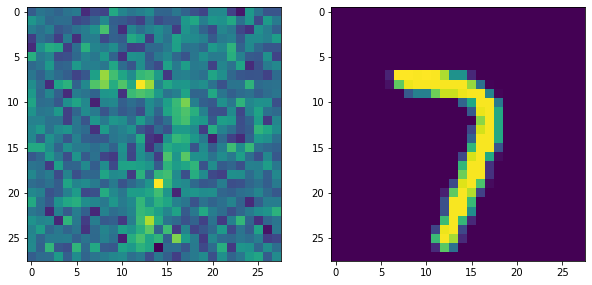

Epoch [24/100], Loss: 0.0693, Validation Loss 0.0687


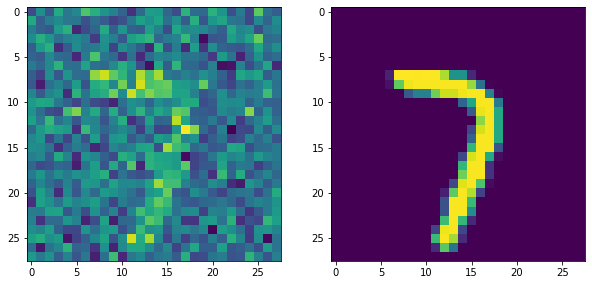

Epoch [25/100], Loss: 0.0688, Validation Loss 0.0687


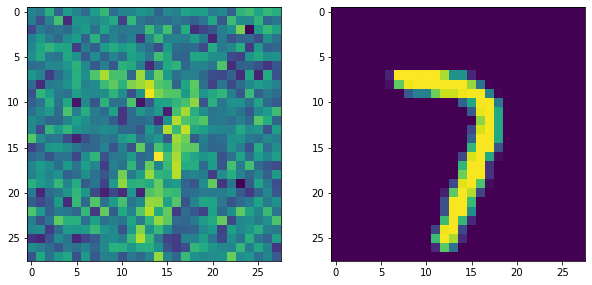

Epoch [26/100], Loss: 0.0684, Validation Loss 0.0682


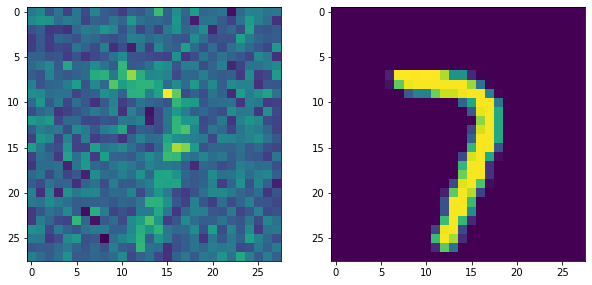

Epoch [27/100], Loss: 0.0679, Validation Loss 0.0674


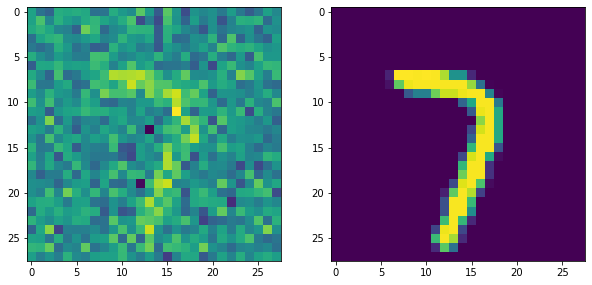

Epoch [28/100], Loss: 0.0675, Validation Loss 0.0680


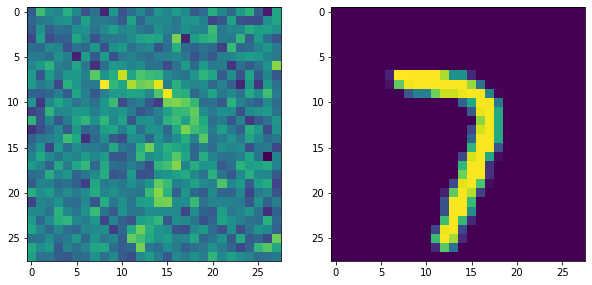

Epoch [29/100], Loss: 0.0671, Validation Loss 0.0664


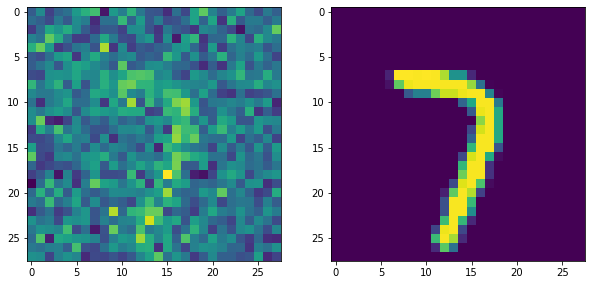

Epoch [30/100], Loss: 0.0671, Validation Loss 0.0661


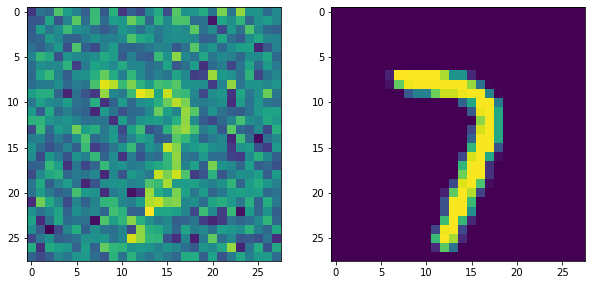

Epoch [31/100], Loss: 0.0663, Validation Loss 0.0665


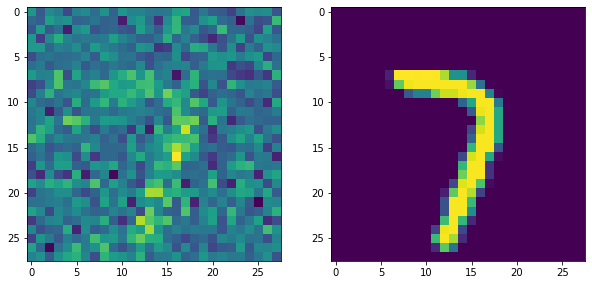

Epoch [32/100], Loss: 0.0660, Validation Loss 0.0655


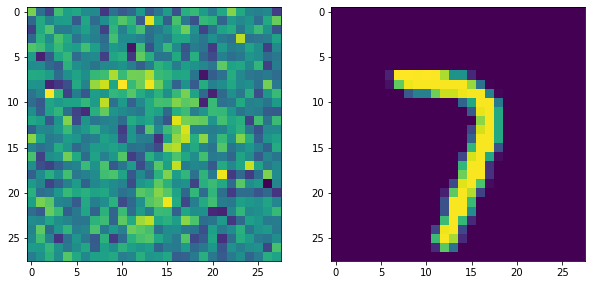

Epoch [33/100], Loss: 0.0656, Validation Loss 0.0652


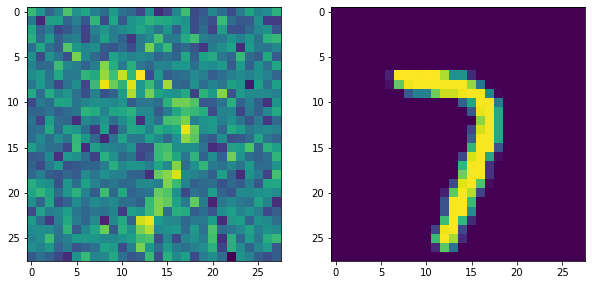

Epoch [34/100], Loss: 0.0653, Validation Loss 0.0648


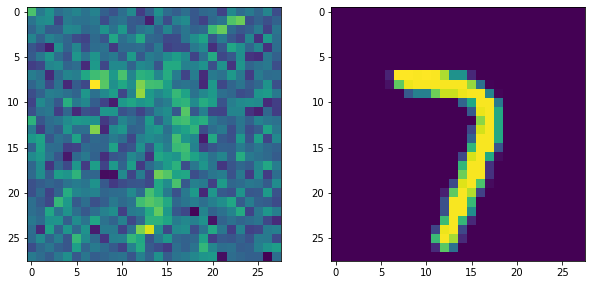

Epoch [35/100], Loss: 0.0649, Validation Loss 0.0644


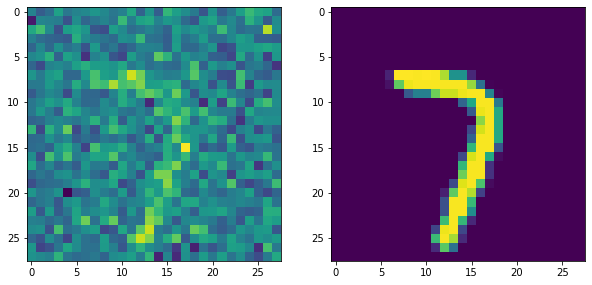

Epoch [36/100], Loss: 0.0646, Validation Loss 0.0644


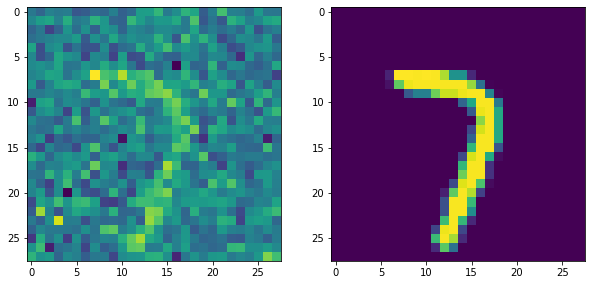

Epoch [37/100], Loss: 0.0643, Validation Loss 0.0641


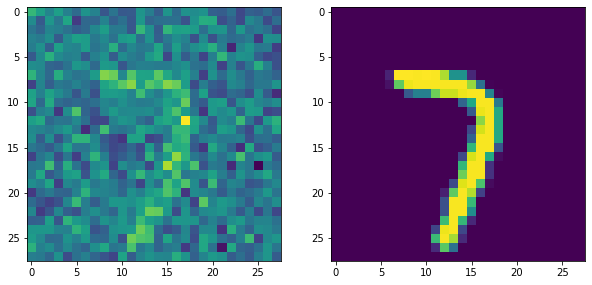

Epoch [38/100], Loss: 0.0641, Validation Loss 0.0637


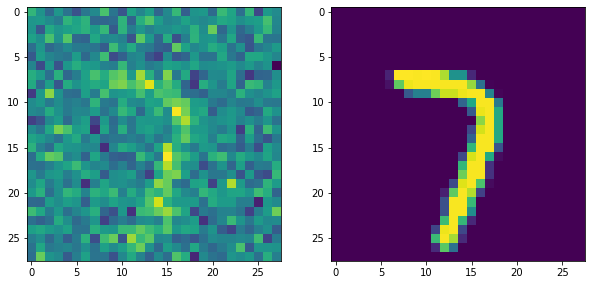

Epoch [39/100], Loss: 0.0637, Validation Loss 0.0642


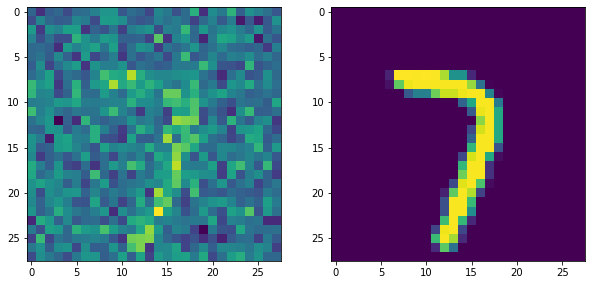

Epoch [40/100], Loss: 0.0634, Validation Loss 0.0633


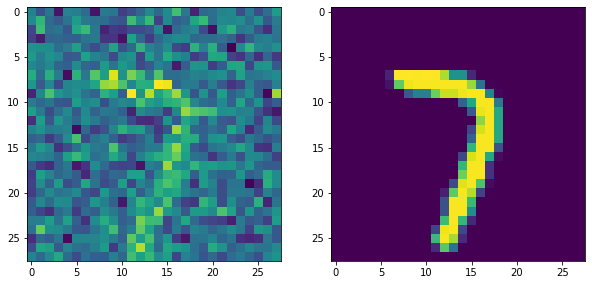

Epoch [41/100], Loss: 0.0632, Validation Loss 0.0629


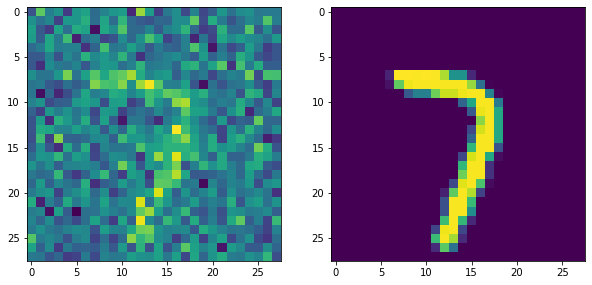

Epoch [42/100], Loss: 0.0629, Validation Loss 0.0625


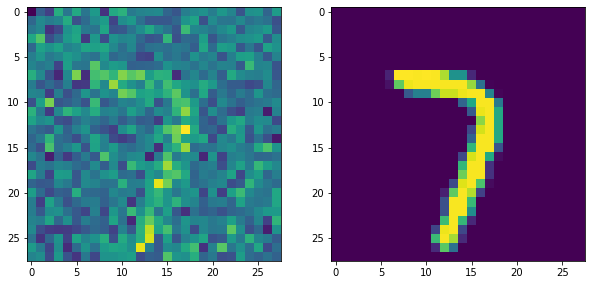

Epoch [43/100], Loss: 0.0627, Validation Loss 0.0625


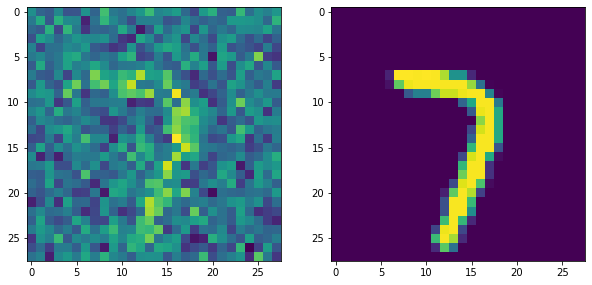

Epoch [44/100], Loss: 0.0624, Validation Loss 0.0625


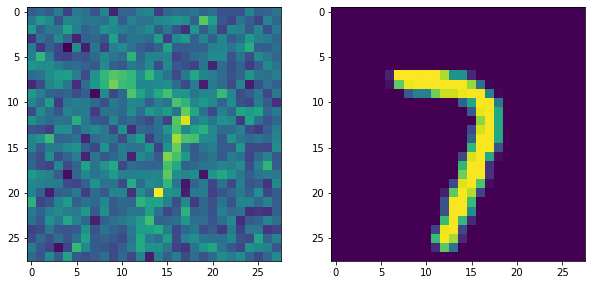

Epoch [45/100], Loss: 0.0621, Validation Loss 0.0618


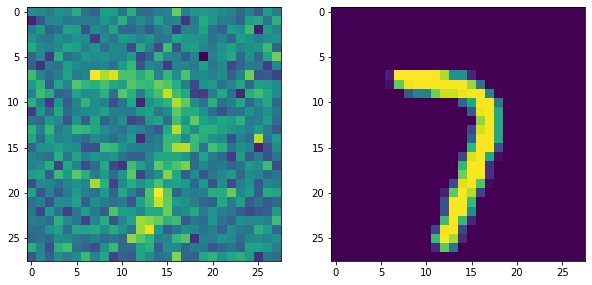

Epoch [46/100], Loss: 0.0619, Validation Loss 0.0615


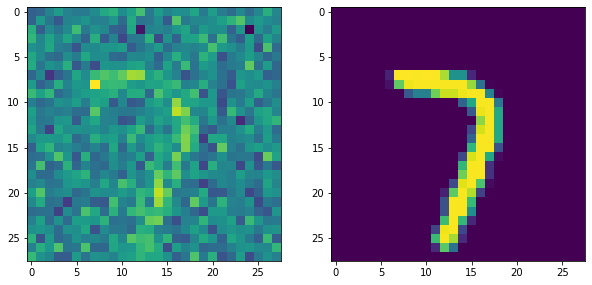

Epoch [47/100], Loss: 0.0617, Validation Loss 0.0614


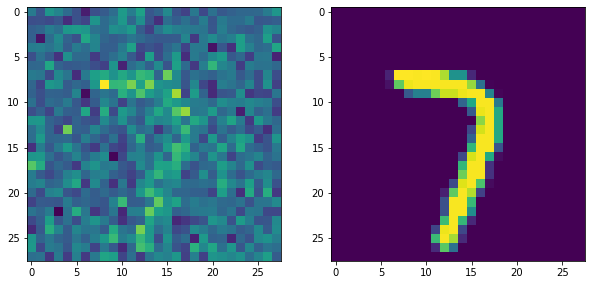

Epoch [48/100], Loss: 0.0615, Validation Loss 0.0614


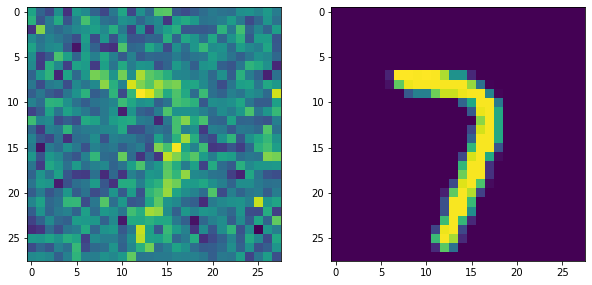

Epoch [49/100], Loss: 0.0613, Validation Loss 0.0610


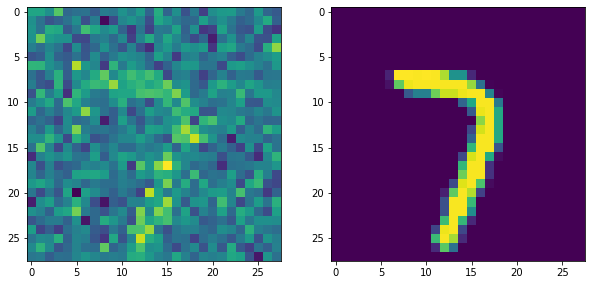

Epoch [50/100], Loss: 0.0612, Validation Loss 0.0616


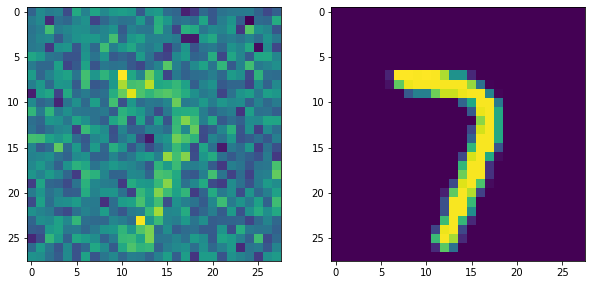

Epoch [51/100], Loss: 0.0612, Validation Loss 0.0610


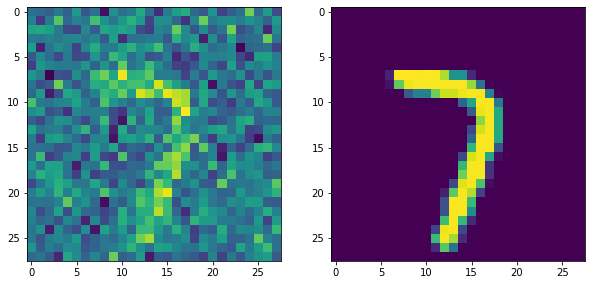

Epoch [52/100], Loss: 0.0606, Validation Loss 0.0607


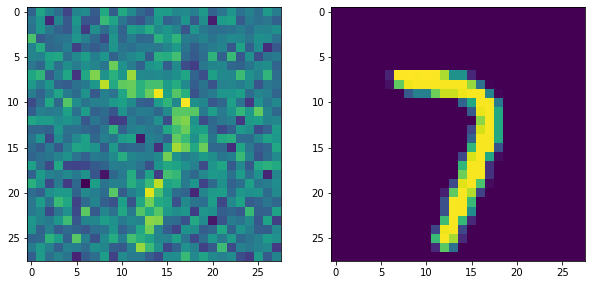

Epoch [53/100], Loss: 0.0604, Validation Loss 0.0601


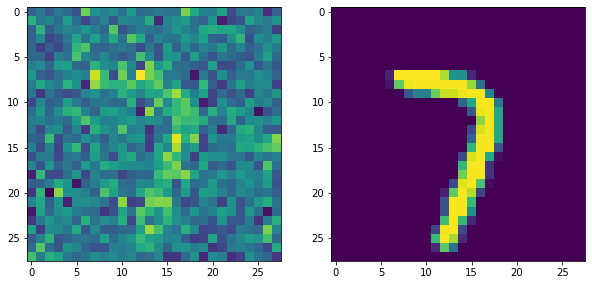

Epoch [54/100], Loss: 0.0603, Validation Loss 0.0599


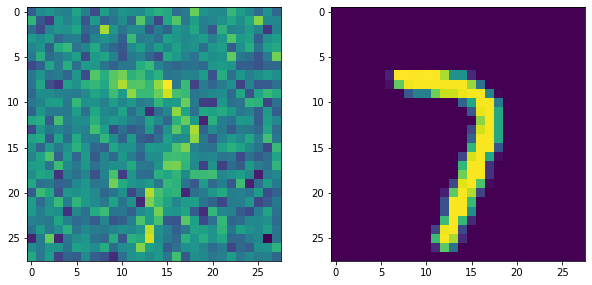

Epoch [55/100], Loss: 0.0601, Validation Loss 0.0598


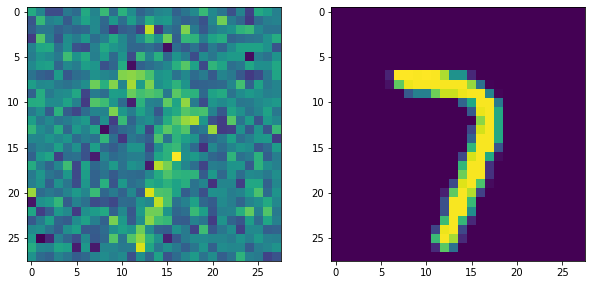

Epoch [56/100], Loss: 0.0599, Validation Loss 0.0608


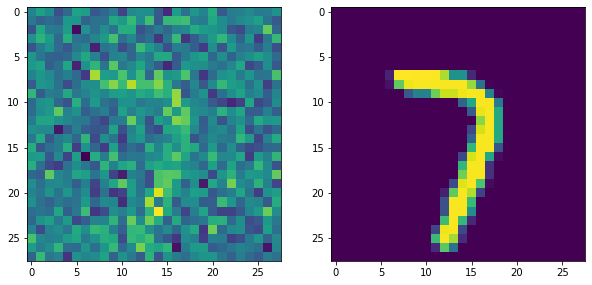

Epoch [57/100], Loss: 0.0598, Validation Loss 0.0595


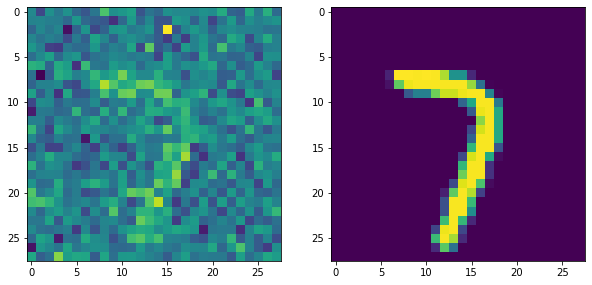

Epoch [58/100], Loss: 0.0596, Validation Loss 0.0591


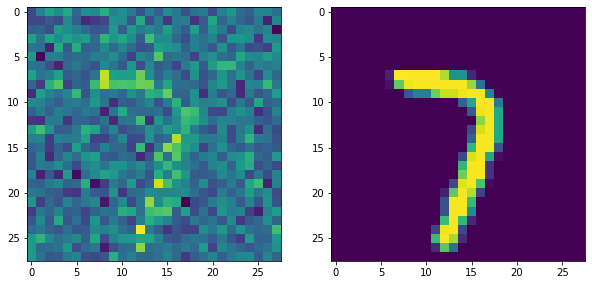

Epoch [59/100], Loss: 0.0600, Validation Loss 0.0592


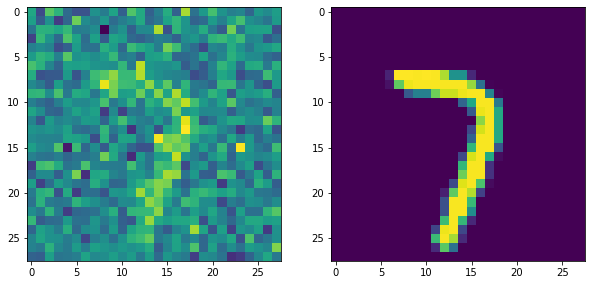

Epoch [60/100], Loss: 0.0592, Validation Loss 0.0590


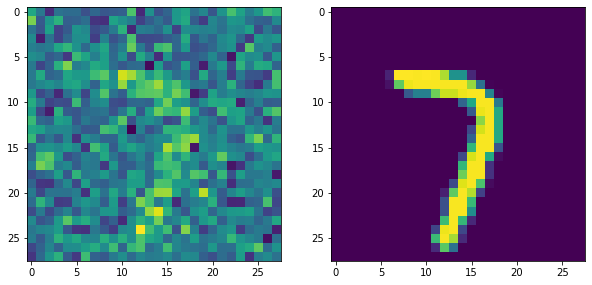

Epoch [61/100], Loss: 0.0591, Validation Loss 0.0589


In [ ]:
model = AE()

num_epochs = 100
lr = .0001

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

criterion = nn.L1Loss()

all_losses = [3,4]
all_validation_losses = [4,7]

best_loss = 10

model.train()

for epoch in range(num_epochs):
	# Training
	total_loss = 0
	for x, label in iter(train_loader):
		out = model(x)

		loss = criterion(out, label.squeeze())
		total_loss += loss

		# Backward and optimize
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
	avg_loss = total_loss / len(train_loader)
 
	if (avg_loss < best_loss):
		torch.save(model.state_dict(), "best-model.bin")

 
	all_losses.append(avg_loss)
	
	# Show example from generation
	x, validation = next(iter(val_loader))
	f, ax = plt.subplots(1, 2, figsize=(10, 10))
	ax[0].imshow(x[0].squeeze().numpy())
	ax[1].imshow(validation[0].squeeze().numpy())
	plt.show()
	
	# Evaluating
	validation_total_loss = 0
	for x, validation in iter(val_loader):
		out = model(x)
		loss = criterion(out, validation.squeeze())
		validation_total_loss += loss
	validation_avg_loss = validation_total_loss / len(val_loader)
 
	all_validation_losses.append(validation_avg_loss)

	print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}, Validation Loss {validation_avg_loss:.4f}")
 

# Load best model and evaluate on trainging set
best_model = AE()
best_model.load_state_dict(torch.load("best-model.bin"))
total_loss = 0
for x, label in iter(test_loader):
	out = model(x)
	loss = criterion(out, label.squeeze())
	total_loss += loss
avg_loss = total_loss / len(test_loader)

print(f"Best model had loss of {avg_loss:.4f}")

 # Show graph
f, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].plot(all_losses)
ax[1].plot(all_validation_losses)
plt.show()





In [ ]:
model = AE()

num_epochs = 100
lr = .0001

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

criterion = nn.MSELoss()

all_losses = [3,4]
all_validation_losses = [4,7]

best_loss = 10

model.train()

for epoch in range(num_epochs):
	# Training
	total_loss = 0
	for x, label in iter(train_loader):
		out = model(x)

		loss = criterion(out, label.squeeze())
		total_loss += loss

		# Backward and optimize
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
	avg_loss = total_loss / len(train_loader)
 
	if (avg_loss < best_loss):
		torch.save(model.state_dict(), "best-model.bin")

 
	all_losses.append(avg_loss)
	
	# Show example from generation
	x, validation = next(iter(val_loader))
	f, ax = plt.subplots(1, 2, figsize=(10, 10))
	ax[0].imshow(x[0].squeeze().numpy())
	ax[1].imshow(validation[0].squeeze().numpy())
	plt.show()
	
	# Evaluating
	validation_total_loss = 0
	for x, validation in iter(val_loader):
		out = model(x)
		loss = criterion(out, validation.squeeze())
		validation_total_loss += loss
	validation_avg_loss = validation_total_loss / len(val_loader)
 
	all_validation_losses.append(validation_avg_loss)

	print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}, Validation Loss {validation_avg_loss:.4f}")
 

# Load best model and evaluate on trainging set
best_model = AE()
best_model.load_state_dict(torch.load("best-model.bin"))
total_loss = 0
for x, label in iter(test_loader):
	out = model(x)
	loss = criterion(out, label.squeeze())
	total_loss += loss
avg_loss = total_loss / len(test_loader)

print(f"Best model had loss of {avg_loss:.4f}")

 # Show graph
f, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].plot(all_losses)
ax[1].plot(all_validation_losses)
plt.show()